# Movie Recommendation System

The task is to build a model that provides top 5 movie recommendations to a user, based on their ratings of other movies.

### EDA Right now, checking to see which data will help up with our business problem

In [1]:
# Importing pandas to analyze csv files
import pandas as pd

# Adding a variable for each csv file
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

### Looking at all dataframes to see what could/isn't useful to the business problem

In [2]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [3]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [4]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [5]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


### Looking at all these dataframes, there are many ways I see that we could go about making a movie recommendation system off the present data. Looking at these dataframes on paper, we could:

- Make a recommendation system that gives top movie in certain genres based off ratings
- Make a recommendation system based off tags rather than genre using ratings
#### Let's start with a recommendation system based on genre by rating for now. 

In [6]:
genre_ratings = pd.merge(movies, ratings, how="left", on="movieId")

genre_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [7]:
genre_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100854 entries, 0 to 100853
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100854 non-null  int64  
 1   title      100854 non-null  object 
 2   genres     100854 non-null  object 
 3   userId     100836 non-null  float64
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 4.6+ MB


In [8]:
## Only 18-54 rows that are non-null out of 100k? Yeah, let's drop that.
genre_ratings.dropna()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


## Now that we have this movie genre rating combined with the user's ratings, doing more EDAs to see how to properly make this recommendation system. 

## Oh yeah, I have remember that I forgot to turn the data column into an actual date thing so I could possibly filter ratings to be more recent rather than of all time.

In [9]:
# Analyzing each column before taking further steps

# Looking at how many different movies are in the dataframe
print("There are", genre_ratings['title'].nunique(), "total movies in the dataset\n")

# Looking at how many genre combos are in the dataframe
print("There are", genre_ratings['genres'].nunique(), "unique genre combinations in this dataframe, appearing from as much as 7k rows to 1 row.\n")

# Looking at how many users/user entries are in the data
genre_ratings['userId'].value_counts().sort_index()
print("There is data from 610 total users, where the max ratings given from one user is 2.7k and the minimum 20.")

There are 9737 total movies in the dataset

There are 951 unique genre combinations in this dataframe, appearing from as much as 7k rows to 1 row.

There is data from 610 total users, where the max ratings given from one user is 2.7k and the minimum 20.


#### Should I waste my time my time going through the genre column to seperate each column?  I'm thinking of doing a for loop to split the genre values by the "|" and then trying to find how many total individual unique genres there are instead of genre combos to better deepen how many recommendations we can give one person... whatever let me try it...

In [10]:
genre_combos = list(genre_ratings['genres'].unique())
print("The genre_combos variable is a list of", type(genre_combos[0]), "based off the movies in the data.")

unique_genres = []

for genre_combo in genre_combos:
    genres = genre_combo.split("|")
    for genre in genres:
        if genre not in unique_genres:
            unique_genres.append(genre)
        
unique_genres

The genre_combos variable is a list of <class 'str'> based off the movies in the data.


['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

#### Now I have an idea to see the mean ratings of each genre, even though it most likely won't be useful for the analysis, at least in my head...

In [11]:
genre_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09
...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09


In [12]:
# Trying to create a function that will create new columns for each genre
def genre_column(genre):
    
    genre_ratings[genre] = genre_ratings['genres'].str.contains(genre)
    
    print("The", genre, "genre has this T/F ratio: ", genre_ratings[genre].value_counts())
    print("The average rating for this genre is", genre_ratings[genre_ratings[genre]]['rating'].mean(), "\n")

for genre in unique_genres:
    genre_column(genre)

The Adventure genre has this T/F ratio:  Adventure
False    76692
True     24162
Name: count, dtype: int64
The average rating for this genre is 3.5086089151939075 

The Animation genre has this T/F ratio:  Animation
False    93865
True      6989
Name: count, dtype: int64
The average rating for this genre is 3.6299370349170004 

The Children genre has this T/F ratio:  Children
False    91646
True      9208
Name: count, dtype: int64
The average rating for this genre is 3.412956125108601 

The Comedy genre has this T/F ratio:  Comedy
False    61798
True     39056
Name: count, dtype: int64
The average rating for this genre is 3.3847207640898267 

The Fantasy genre has this T/F ratio:  Fantasy
False    89019
True     11835
Name: count, dtype: int64
The average rating for this genre is 3.4910005070136894 

The Romance genre has this T/F ratio:  Romance
False    82725
True     18129
Name: count, dtype: int64
The average rating for this genre is 3.5065107040388437 

The Drama genre has this T/

C:\Users\mansi\AppData\Local\Temp\ipykernel_28736\4085807863.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  genre_ratings[genre] = genre_ratings['genres'].str.contains(genre)


In [13]:
genre_ratings

,movieId,title,genres,userId,rating,timestamp,Adventure,Animation,Children,Comedy,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Filtering for the rows that have no genre at all
genre_ratings = genre_ratings[genre_ratings['(no genres listed)']==False]

# Dropping the "no genre" column itself
genre_ratings.drop('(no genres listed)', axis=1, inplace=True)

genre_ratings

C:\Users\mansi\AppData\Local\Temp\ipykernel_28736\1374017455.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_ratings.drop('(no genres listed)', axis=1, inplace=True)


,movieId,title,genres,userId,rating,timestamp,Adventure,Animation,Children,Comedy,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,1.537109e+09,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,1.537110e+09,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100851,193585,Flint (2017),Drama,184.0,3.5,1.537110e+09,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,1.537110e+09,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Changing the timestamp time format to something readable to everyone lol

In [15]:
# Like bro what is this
genre_ratings['timestamp'][0]

964982703.0

#### Nice, now all of the rows in the timestamp column are readable

In [16]:
genre_ratings['timestamp'] = pd.to_datetime(pd.to_datetime(genre_ratings['timestamp'], unit='s'))
print(genre_ratings['timestamp'].head())
genre_ratings['timestamp'].tail()

0   2000-07-30 18:45:03
1   1996-11-08 06:36:02
2   2005-01-25 06:52:26
3   2017-11-13 12:59:30
4   2011-05-18 05:28:03
Name: timestamp, dtype: datetime64[ns]


C:\Users\mansi\AppData\Local\Temp\ipykernel_28736\3190169147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_ratings['timestamp'] = pd.to_datetime(pd.to_datetime(genre_ratings['timestamp'], unit='s'))


100849   2018-09-16 14:44:42
100850   2018-09-16 14:52:25
100851   2018-09-16 14:56:45
100852   2018-09-16 15:00:21
100853   2018-09-17 04:13:26
Name: timestamp, dtype: datetime64[ns]

#### Dataframe has movies ratings from 1996 to 2018

In [17]:
sort_date = genre_ratings.sort_values(by='timestamp')
print(sort_date['timestamp'].head(1))
sort_date.tail(20)

16167   1996-03-29 18:36:55
Name: timestamp, dtype: datetime64[ns]


,movieId,title,genres,userId,rating,timestamp,Adventure,Animation,Children,Comedy,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
66121,5246,Smokey and the Bandit II (1980),Action|Comedy,514.0,1.5,2018-09-24 02:44:19,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4720,162,Crumb (1994),Documentary,514.0,4.0,2018-09-24 14:27:30,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
22820,1076,"Innocents, The (1961)",Drama|Horror|Thriller,NaN,NaN,NaT,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
49539,2939,Niagara (1953),Drama|Thriller,NaN,NaN,NaT,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
53555,3338,For All Mankind (1989),Documentary,NaN,NaN,NaT,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
54467,3456,"Color of Paradise, The (Rang-e khoda) (1999)",Drama,NaN,NaN,NaT,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
60535,4194,I Know Where I'm Going! (1945),Drama|Romance|War,NaN,NaN,NaT,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
68396,5721,"Chosen, The (1981)",Drama,NaN,NaN,NaT,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
71896,6668,"Road Home, The (Wo de fu qin mu qin) (1999)",Drama|Romance,NaN,NaN,NaT,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
72428,6849,Scrooge (1970),Drama|Fantasy|Musical,NaN,NaN,NaT,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


#### Getting rid of the last 18 rows that have no data for users/dates

In [18]:
sort_date = sort_date.tail(18)

genre_ratings.drop(sort_date.index, inplace=True)

genre_ratings

C:\Users\mansi\AppData\Local\Temp\ipykernel_28736\4000396963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_ratings.drop(sort_date.index, inplace=True)


,movieId,title,genres,userId,rating,timestamp,Adventure,Animation,Children,Comedy,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,2018-09-16 14:44:42,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,2018-09-16 14:52:25,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100851,193585,Flint (2017),Drama,184.0,3.5,2018-09-16 14:56:45,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,2018-09-16 15:00:21,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


### When it comes to the visualization side of things, using the data, we could show-
- Top movies sorted by popularity (most ratings / appears the most)
- Top highest rated movies from the dataset
- ALL genre type's w/average ratings
- MAYBE all tags

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<Axes: ylabel='title'>

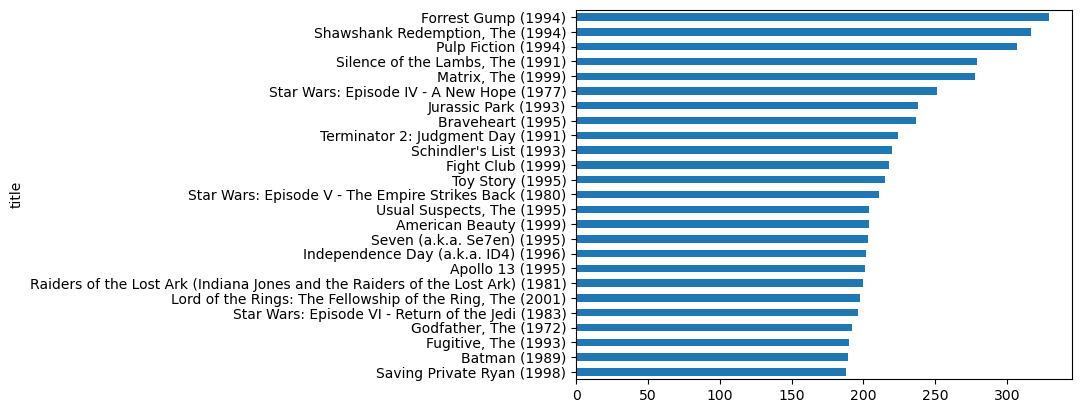

In [42]:
# Top 10 most popular movies based off how much they were rated in the data
genre_ratings['title'].value_counts().sort_values(ascending=True).tail(25).plot(kind='barh')

<Axes: ylabel='title'>

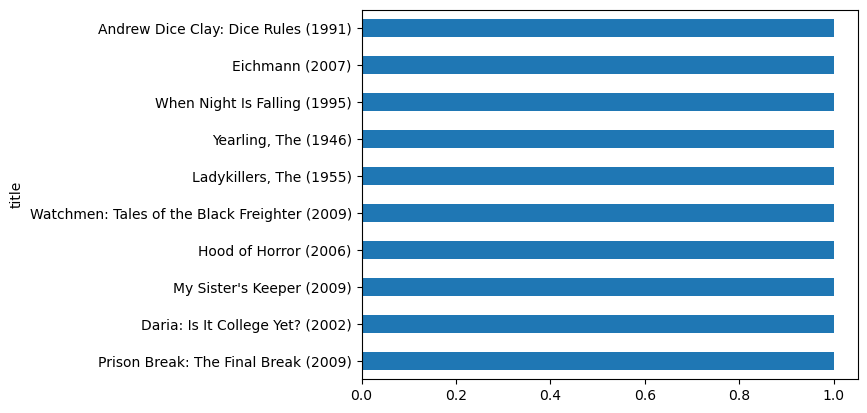

In [43]:
# 10 least popular movies (Have 1 rating)
# There is actually over 200 movies with 1 rating
# Could be bad because if 1 person rates a movie a 5, it has an average
# of 5, meaning it must be suuuper good to machine learning
genre_ratings['title'].value_counts().tail(10).plot(kind='barh')

<Axes: xlabel='title'>

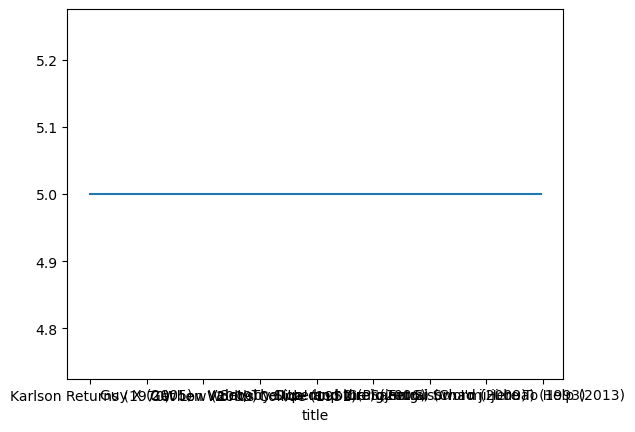

In [23]:
# Looking at this, there are A LOT of numbers rated an average of 5
# because they were rated only once and given a 5

genre_ratings.groupby('title')['rating'].mean().sort_values(ascending=False).head(200).plot()

In [30]:
# Looking to find just how many movies are rated once

# First, creating a variable that has all of the movies
least_pop = genre_ratings.drop_duplicates('title', keep=False)

# Now, looking at all the movies that only appear ONCE
print("There are", len(least_pop), "movies that only appear once.")

There are 3414 movies that only appear once.


#### Now that I have made seperate columns, making a recommendation system with the current data to see how it works and improving from there.

#### The overall goal of the recommendation system is to recommend each user 5 movies based on their ratings. Here is how I believe it would function perfectly on paper straight off the top of my mind:

⁣⁣⁣
The main function is to recommend 5 movies. The recommended movies have to fit in the following:
- The 5 movies within the same genre/similar to what a user rates the highest
- The 5 movies DON'T recommend similar movies a user rates low
- The 5 movies are new/haven't already been watched by that user
- The 5 movies are biased to a user's more recent ratings 
- Maybe recommend what other people who watched their highest rated movie liked
- The recommended movies are also highly rated over all time
- System goes into a user's movie ratings till it gets 5 movies rated 5
- If they hate a lot of movies and only like the first movie they watched
- Like get a user's highest and their lowest rated movies and recommended based off that, and most recent of those
- Maybe get their mean ratings for each genre and recommend it based off of that, don't recommend same movies again

In [25]:
genre_ratings

,movieId,title,genres,userId,rating,timestamp,Adventure,Animation,Children,Comedy,...,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100849,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184.0,4.0,2018-09-16 14:44:42,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100850,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184.0,3.5,2018-09-16 14:52:25,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
100851,193585,Flint (2017),Drama,184.0,3.5,2018-09-16 14:56:45,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
100852,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184.0,3.5,2018-09-16 15:00:21,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [26]:
import surprise
from surprise import Dataset, Reader
from surprise.prediction_algorithms import *
from surprise import accuracy
from sklearn.model_selection import train_test_split

In [27]:
train_df, test_df = train_test_split(genre_ratings, test_size = .25)

reader = Reader(rating_scale = (1, 5))
data = Dataset.load_from_df(train_df[['userId', 'movieId', "rating"]], reader)
trainset = data.build_full_trainset()

In [28]:
model_svd = SVD()
model_svd.fit(trainset)

predictions_svd = model_svd.test(trainset.build_anti_testset())
accuracy.rmse(predictions_svd)

RMSE: 0.4655


0.46546750108389706

In [ ]:
def get_top_n_recommendations(user_id, n=5):
    user_movies = genre_ratings[genre_ratings['userId'] == user_id]['movieId'].unique()
    all_movies = genre_ratings['title'].unique()
    movies_to_predict = list(set(all_movies) - set(user_movies))
    
    user_movie_pairs = [(user_id, movie_id, 0) for movie_id in movies_to_predict]
    predictions_cf = model_svd.test(user_movie_pairs)
    
    top_n_recommendations = sorted(predictions_cf, key = lambda x: x.est, reverse = True)[:n]
    
    top_n_movie_ids = [int(pred.iid) for pred in top_n_recommendations]
    
    top_n_movies = movie_encoder.inverse_transform(top_n_movie_ids)
    
    return top_n_movies

In [ ]:
user_id = 500
recommendations = get_top_n_recommendations(user_id)
top_n_movies_titles = movies_df[movies_df['movieId'].isin(recommendations)]['title'].tolist()
print(f"Top 5 Recommendations for User {user_id}:")
for i, title in enumerate(top_n_movies_titles, 1):
  print(f"{i}.{title}")